In [1]:
import zipfile
import os

In [2]:
# List of directories you want to create
directories = ['/kaggle/working/CSVS', '/kaggle/working/DATASET', '/kaggle/working/ckpts']

# Loop through each directory and create it if it doesn't exist
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory already exists: {directory}")

Created directory: /kaggle/working/CSVS
Created directory: /kaggle/working/DATASET
Created directory: /kaggle/working/ckpts


In [3]:
# !cp /kaggle/input/signet-data/signet_ensemble/signet_v2.h5 /kaggle/working/ckpts/signet.h5

## Start working from here
* Dataset paths:
1. English-> /kaggle/input/english-cedar/CEDAR/CEDAR
2. Hindi-> /kaggle/input/hindi-signatures/BHSig260-Hindi/BHSig260-Hindi
3. Bengali-> /kaggle/input/bengali-signatures-data/BHSig260-Bengali/BHSig260-Bengali

In [4]:
import os
import pandas as pd
from itertools import combinations
import random
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import cv2
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
def create_signature_dataframe(root_folder, random_state=None, is_english = False):
    data = []
    gen = "G"
    fake = "F"
    
    if is_english:
        gen = "original"
        fake = "forgeries"

    # Set the seed for reproducibility
    random.seed(random_state)

    # List all subfolders (corresponding to different people)
    person_folders = os.listdir(root_folder)

    # Iterate through each person's folder
    for person_folder in person_folders:
        person_path = os.path.join(root_folder, person_folder)

        # List all original signatures
        original_signatures = [os.path.join(person_path, filename) for filename in os.listdir(person_path) if gen in filename]

        # List all forged signatures
        forged_signatures = [os.path.join(person_path, filename) for filename in os.listdir(person_path) if fake in filename]

        # Create combinations of genuine-genuine pairs
        genuine_genuine_pairs = list(combinations(original_signatures, 2))

        # Create combinations of genuine-forged pairs
        genuine_forged_pairs = [(original, forged) for original in original_signatures for forged in forged_signatures]

        # Balance the classes within each person's data
        min_class_size = min(len(genuine_genuine_pairs), len(genuine_forged_pairs))

        # Add genuine-genuine pairs to the dataframe with label 1
        data.extend([(pair[0], pair[1], 1) for pair in random.sample(genuine_genuine_pairs, min_class_size)])

        # Add genuine-forged pairs to the dataframe with label 0
        data.extend([(pair[0], pair[1], 0) for pair in random.sample(genuine_forged_pairs, min_class_size)])

    print(f"Data length after adding same-person pairs: {len(data)}")

    # Add negative samples (genuine signature from one person and any signature from another person)
    cross_person_pairs_count = 0
    max_cross_person_pairs_count = 2 * len(data)  # Maximum allowed cross-person pairs

    for i in range(len(person_folders)):
        if cross_person_pairs_count >= max_cross_person_pairs_count:
            break

        for j in range(i+1, len(person_folders)):
            if cross_person_pairs_count >= max_cross_person_pairs_count:
                break

            person_i_path = os.path.join(root_folder, person_folders[i])
            person_j_path = os.path.join(root_folder, person_folders[j])

            original_i_signatures = [os.path.join(person_i_path, filename) for filename in os.listdir(person_i_path) if gen in filename]
            original_j_signatures = [os.path.join(person_j_path, filename) for filename in os.listdir(person_j_path) if gen in filename]

            forged_j_signatures = [os.path.join(person_j_path, filename) for filename in os.listdir(person_j_path) if fake in filename]

            all_j_signatures = original_j_signatures + forged_j_signatures

            # Create combinations of genuine-genuine pairs across different folders
            cross_person_pairs = [(original_i, signature_j) for original_i in original_i_signatures for signature_j in all_j_signatures]

            # Add these pairs to the dataframe with label 0
            num_pairs_to_add = min(len(cross_person_pairs), max_cross_person_pairs_count - cross_person_pairs_count)
            data.extend([(pair[0], pair[1], 0) for pair in cross_person_pairs[:num_pairs_to_add]])
            cross_person_pairs_count += num_pairs_to_add

    print(f"Data length after adding cross-person pairs: {len(data)}")

    # Shuffle the data for randomness
    random.shuffle(data)

    # Create a dataframe
    df = pd.DataFrame(data, columns=["anchor_image", "image_2_in", "label"])

    return df

In [9]:
def split_dataframe(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=None):
    # Check if ratios sum to 1
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("Ratios must sum to 1")

    # Compute actual ratios
    test_actual = test_ratio / (val_ratio + test_ratio)
    val_actual = 1.0 - test_actual

    # Split into train and temp dataframes
    df_train, df_temp = train_test_split(df, test_size=1-train_ratio, random_state=random_state)

    # Split temp dataframe into validation and test dataframes
    df_val, df_test = train_test_split(df_temp, test_size=test_actual, random_state=random_state)

    return df_train, df_val, df_test

In [10]:
import pandas as pd
from sklearn.utils import shuffle

def merge_and_balance(hindi_df, english_df, bengali_df):
    # Get the minimum length among the three dataframes
    min_len = min(len(hindi_df), len(english_df), len(bengali_df))

    # Trim each dataframe to the minimum length
    hindi_df = hindi_df.sample(n=min_len)
    english_df = english_df.sample(n=min_len)
    bengali_df = bengali_df.sample(n=min_len)

    # Concatenate and shuffle
    result_df = pd.concat([hindi_df, english_df, bengali_df])
    result_df = shuffle(result_df)

    # Reset index
    result_df.reset_index(drop=True, inplace=True)

    return result_df

def reduce_dataframe(df, reduction_factor=0.5):
    # Get the unique labels in the dataframe
    labels = df['label'].unique()

    reduced_df = pd.DataFrame()

    for label in labels:
        # Filter the dataframe by label
        label_df = df[df['label'] == label]

        # Determine the number of samples to keep
        n_samples = int(len(label_df) * reduction_factor)

        # Sample the dataframe
        reduced_label_df = label_df.sample(n=n_samples)

        # Append to the reduced dataframe
        reduced_df = pd.concat([reduced_df, reduced_label_df])

    # Shuffle the dataframe and reset the index
    reduced_df = reduced_df.sample(frac=1).reset_index(drop=True)

    return reduced_df

def balance_dataframe(df):
    # Get the unique labels in the dataframe
    labels = df['label'].unique()

    balanced_df = pd.DataFrame()

    # Determine the minimum number of samples across all labels
    min_samples = min([len(df[df['label'] == label]) for label in labels])

    for label in labels:
        # Filter the dataframe by label
        label_df = df[df['label'] == label]

        # Sample the dataframe
        balanced_label_df = label_df.sample(n=min_samples)

        # Append to the balanced dataframe
        balanced_df = pd.concat([balanced_df, balanced_label_df])

    # Shuffle the dataframe and reset the index
    balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

    return balanced_df

In [11]:
# Specify the root folder containing subfolders for each person
english_folder = "/kaggle/input/english-cedar/CEDAR/CEDAR"
hindi_folder = "/kaggle/input/hindi-signatures/BHSig260-Hindi/BHSig260-Hindi"
bengali_fodler = "/kaggle/input/bengali-signatures-data/BHSig260-Bengali/BHSig260-Bengali"

# Create the dataframe
english_df = create_signature_dataframe(english_folder, random_state=42, is_english=True)
hindi_df = create_signature_dataframe(hindi_folder, random_state=42)
bengali_df = create_signature_dataframe(bengali_fodler, random_state=42)

balanced_df = merge_and_balance(english_df, hindi_df, bengali_df)
# reduced_df = reduce_dataframe(balanced_df, 0.4)
# balanced_df_classes = balance_dataframe(balanced_df)


train_df, val_df, test_df = split_dataframe(balanced_df, random_state=42)

Data length after adding same-person pairs: 30360
Data length after adding cross-person pairs: 91080
Data length after adding same-person pairs: 88320
Data length after adding cross-person pairs: 264960
Data length after adding same-person pairs: 55200
Data length after adding cross-person pairs: 165600


In [12]:
hindi_df.shape, english_df.shape, bengali_df.shape

((264960, 3), (91080, 3), (165600, 3))

In [13]:
train_df.shape, val_df.shape, test_df.shape

((191267, 3), (40986, 3), (40987, 3))

In [14]:
print(train_df["label"].value_counts())

label
0    159416
1     31851
Name: count, dtype: int64


In [15]:
# Save the DataFrames to CSV files
train_df.to_csv('/kaggle/working/CSVS/train.csv', index=False)
val_df.to_csv('/kaggle/working/CSVS/val.csv', index=False)
test_df.to_csv('/kaggle/working/CSVS/test.csv', index=False)

In [16]:
def siamese_data_generator(df, target_size=(155, 220), color_mode='grayscale', batch_size=32, train = True):
    # Initialize two image data generators (one for anchor images and one for input images)
    if train:
      anchor_datagen = ImageDataGenerator(
          rescale=1./255,
          rotation_range=20,
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.15,
          zoom_range=0.15,
          # horizontal_flip=True,
          fill_mode='nearest'
      )
      input_datagen = ImageDataGenerator(
          rescale=1./255,
          rotation_range=20,
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.15,
          zoom_range=0.15,
          # horizontal_flip=True,
          fill_mode='nearest'
      )
        
    else:
      print("Not for training")
      anchor_datagen = ImageDataGenerator(rescale=1./255)
      input_datagen = ImageDataGenerator(rescale=1./255)

    # Create data generators
    anchor_generator = anchor_datagen.flow_from_dataframe(
        dataframe=df,
        x_col='anchor_image',
        y_col='label',
        target_size=target_size,
        color_mode=color_mode,
        class_mode='raw',
        batch_size=batch_size,
        shuffle=False  # Ensure data is not shuffled
    )

    input_generator = input_datagen.flow_from_dataframe(
        dataframe=df,
        x_col='image_2_in',
        y_col='label',
        target_size=target_size,
        color_mode=color_mode,
        class_mode='raw',
        batch_size=batch_size,
        shuffle=False  # Ensure data is not shuffled
    )

    while True:
        if not (anchor_generator.batch_index < anchor_generator.n // anchor_generator.batch_size):
            anchor_generator.reset()

        if not (input_generator.batch_index < input_generator.n // input_generator.batch_size):
            input_generator.reset()

        anchor_data = next(anchor_generator)
        input_data = next(input_generator)

        yield [anchor_data[0], input_data[0]], anchor_data[1].astype(np.float32)

In [17]:
def plot_images(image1, image2, labels, idx = 0, title=None):
    """
    Plot two images side by side with labels.

    Args:
        image1 (numpy.ndarray): The first image to be displayed.
        image2 (numpy.ndarray): The second image to be displayed.
        label1 (str): The label for the first image.
        label2 (str): The label for the second image.
        title (str): Optional title for the plot.
    """
    plt.figure(figsize=(10, 5))

    label1 = label2 = labels[idx]

    # Plot the first image on the left
    plt.subplot(1, 2, 1)
    plt.imshow(image1[idx], cmap='gray')  # Assuming grayscale images
    plt.title(label1)
    plt.axis('off')

    # Plot the second image on the right
    plt.subplot(1, 2, 2)
    plt.imshow(image2[idx], cmap='gray')  # Assuming grayscale images
    plt.title(label2)
    plt.axis('off')

    # Add an optional title to the plot
    if title:
        plt.suptitle(title)

    plt.show()

Not for training
Found 40986 validated image filenames.
Found 40986 validated image filenames.


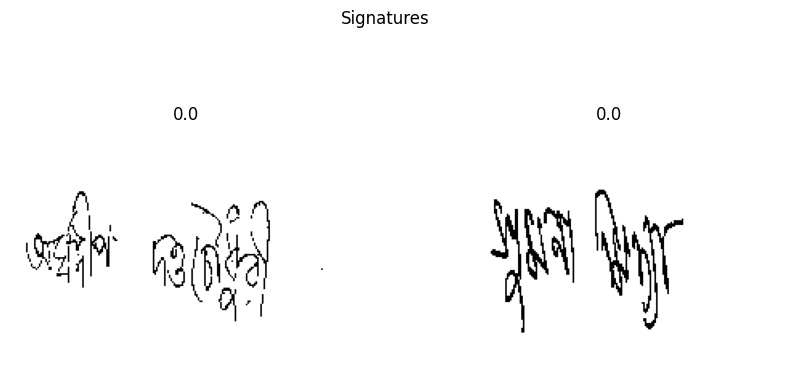

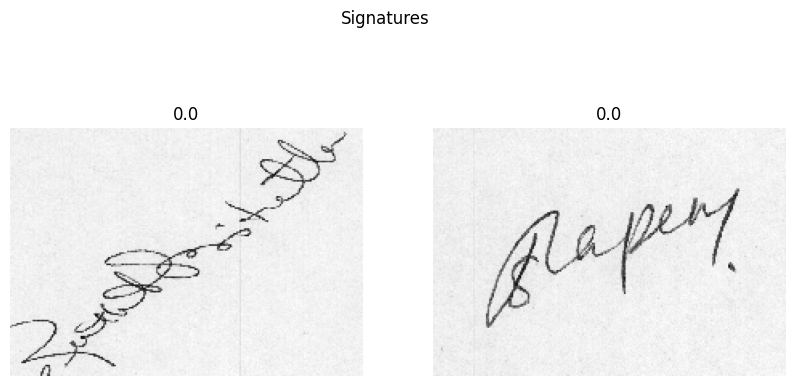

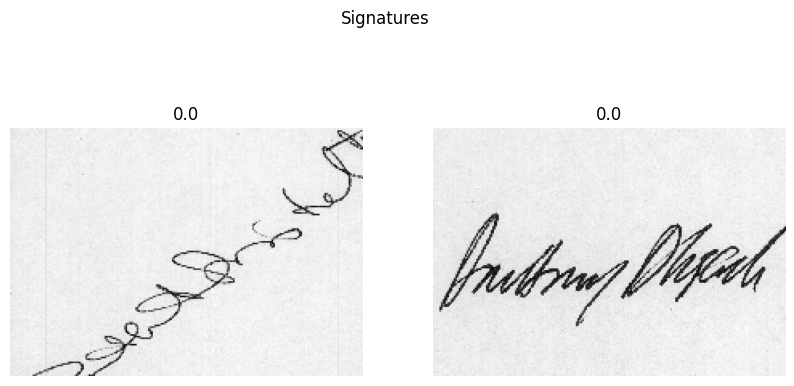

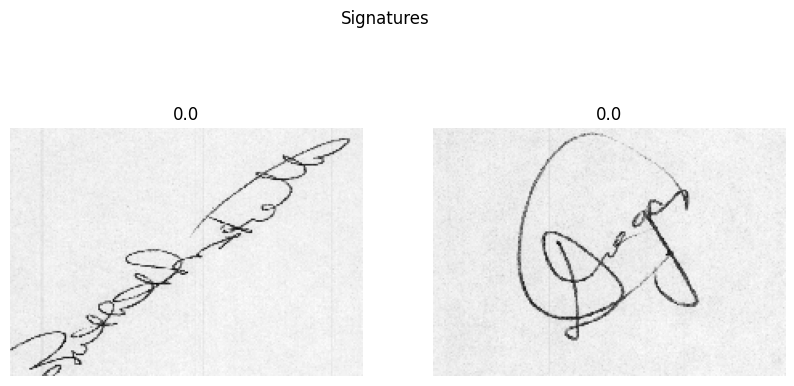

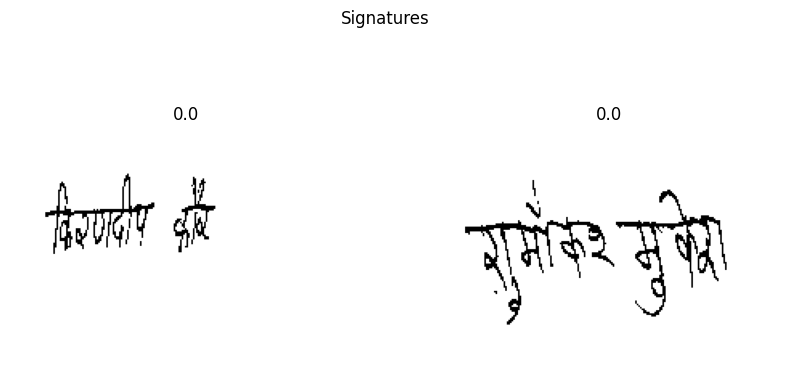

In [18]:
val_datagen = siamese_data_generator(val_df, batch_size=128, train=False)
one_batch = next(val_datagen)
images, labels = one_batch

for i in range(1, 100, 20):
  plot_images(images[0], images[1], labels, i, "Signatures")

del val_datagen

## MODEL

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization, Input, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [20]:
def get_base_net(input_shape):
    '''Base Siamese Network'''
    
    in_image = tf.keras.layers.Input(input_shape)
    
    c1 = tf.keras.layers.Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, 
                                kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0005))(in_image)
    n1 = tf.nn.local_response_normalization(c1, depth_radius=5, bias=1, alpha=0.0001, beta=0.75)
    p1 = tf.keras.layers.MaxPooling2D((3,3), strides=(2, 2))(n1)    
    zp1 = tf.keras.layers.ZeroPadding2D((2, 2))(p1)
    
    c2 = tf.keras.layers.Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, 
                                kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0005))(zp1)
    n2 = tf.nn.local_response_normalization(c2, depth_radius=5, bias=1, alpha=0.0001, beta=0.75)
    p2 = tf.keras.layers.MaxPooling2D((3,3), strides=(2, 2))(n2)
    d1 = tf.keras.layers.Dropout(0.3)(p2) # added extra
    zp2 = tf.keras.layers.ZeroPadding2D((1, 1))(d1)
    
    c3 = tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1,
                                kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0005))(zp2)
    zp3 = tf.keras.layers.ZeroPadding2D((1, 1))(c3)
    
    c4 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1,
                                kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0005))(zp3)    
    p3 = tf.keras.layers.MaxPooling2D((3,3), strides=(2, 2))(c4)
    d2 = tf.keras.layers.Dropout(0.3)(p3) # added extra
    f1 = tf.keras.layers.Flatten(name='flatten')(d2)
    fc1 = tf.keras.layers.Dense(1024, kernel_regularizer=regularizers.l2(0.0005), activation='relu',
                                kernel_initializer='glorot_uniform')(f1)
    d3 = tf.keras.layers.Dropout(0.5)(fc1)
    
    out_embs = tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.0005), activation='relu',
                                     kernel_initializer='glorot_uniform')(d3) # softmax changed to relu
    
    model = tf.keras.models.Model(inputs=in_image, outputs=out_embs)
    
    return model

In [21]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1.0
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1.0 - y_true) * margin_square)

def accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(y_true, tf.cast(y_pred < 0.5, y_true.dtype)), tf.float32))

In [22]:
# Instantiate the distribution strategy
# strategy = tf.distribute.MirroredStrategy()

# # Open a strategy scope and create/compile the model inside it
# with strategy.scope():
input_a = Input(shape=(155, 220, 1))
input_b = Input(shape=(155, 220, 1))

base_net = get_base_net((155, 220, 1))
processed_a = base_net(input_a)
processed_b = base_net(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model = Model([input_a, input_b], distance)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[accuracy])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 128)          6460864     ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

In [23]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-8, verbose=1, initial_lr=1e-4),
    ModelCheckpoint('/kaggle/working/ckpts/signet.h5', verbose=1, save_weights_only=True, save_best_only=True)
]

In [24]:
BATCH_SIZE = 32
TRAIN_STEPS_PER_EPOCH = train_df.shape[0] // BATCH_SIZE - 1
VAL_STEPS_PER_EPOCH = val_df.shape[0] // BATCH_SIZE - 1
TEST_STEPS = test_df.shape[0] // BATCH_SIZE

In [25]:
train_gen = siamese_data_generator(train_df, batch_size=BATCH_SIZE)
valid_gen = siamese_data_generator(val_df, batch_size=BATCH_SIZE, train=False)
test_gen = siamese_data_generator(test_df, batch_size=BATCH_SIZE, train=False)

# ckpt
* /kaggle/working/ckpts/signet.h5

In [26]:
# due to notebook running out of mermory, run training for few epochs, save
# the model and load again to train further

if len(os.listdir("/kaggle/working/ckpts")) > 0:
  model.load_weights("/kaggle/working/ckpts/signet.h5")

In [ ]:
hist = model.fit(train_gen, validation_data=valid_gen, epochs=40,
                steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                validation_steps=VAL_STEPS_PER_EPOCH,
                use_multiprocessing=True,
                workers=6, callbacks = callbacks)

Found 191267 validated image filenames.
Found 191267 validated image filenames.
Epoch 1/40


2023-10-01 06:46:38.053552: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5976/5976 [==============================] - ETA: 0s - loss: 0.2830 - accuracy: 0.8612Not for training
Found 40986 validated image filenames.
Found 40986 validated image filenames.

Epoch 1: val_loss improved from inf to 0.12534, saving model to /kaggle/working/ckpts/signet.h5
5976/5976 [==============================] - 1845s 307ms/step - loss: 0.2830 - accuracy: 0.8612 - val_loss: 0.1253 - val_accuracy: 0.8600 - lr: 1.0000e-04
Epoch 2/40
5976/5976 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9056
Epoch 2: val_loss improved from 0.12534 to 0.10001, saving model to /kaggle/working/ckpts/signet.h5
5976/5976 [==============================] - 1801s 301ms/step - loss: 0.0888 - accuracy: 0.9056 - val_loss: 0.1000 - val_accuracy: 0.8851 - lr: 1.0000e-04
Epoch 3/40
5976/5976 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9105
Epoch 3: val_loss improved from 0.10001 to 0.08287, saving model to /kaggle/working/ckpts/signet.h5
5976/5976 [=====

## TEST

In [ ]:
res = model.evaluate(test_gen, steps = TEST_STEPS)

## Individual Tests